*Copyright (c) Tumiz. Distributed under the terms of the GPL-3.0 License.*

# Simulation of agents

## random agent
**Eg.1** Create a **random agent** and draw its trajectory

In [1]:
from scenario import *
from time import sleep
from random import random
scen = Scenario()
cube=Cube()
cube.position=Vector3(1,1,0.5)
cube.rotation=Rotation.Eular(z=0.3)
traj=Line()
traj.type=Line.Type_Vector
traj.width=2
scen.add(cube,traj)
traj.add_point(cube.position.tolist())
while scen.t<6:
    cube.local_velocity=Vector3.Rand(x=[0,4])
    cube.local_angular_velocity=Rotation.Eular(z=random()-0.4)
    scen.step(0.1)
    traj.add_point(cube.position.tolist())
    scen.render()
    sleep(0.1)

**Eg.2** Create ten random agents

In [10]:
from scenario import *
from time import sleep,time
from random import random
import types
scen = Scenario()
n=10
class Agent(Cube):
    def on_step(self,dt):
        self.local_velocity=Vector3.Rand(x=[0,4])
        self.local_angular_velocity=Rotation.Eular(z=random()-0.5)
for i in range(n):
    cube=Agent()
    cube.position=Vector3(0,0,0.5)
    scen.add(cube)
t=time()
while scen.t<10:
    scen.step(0.1)
    scen.render()
    sleep(0.1)
print(time()-t)

12.306086778640747


**Eg.3** An agent follow a random agent

In [11]:
from scenario import *
from time import sleep
from random import random
scen = Scenario()
cube=Cube()
cube.scale=Vector3(2,1,1)
cube.position=Vector3(3,3,0.5)
cube.color=Color(r=1)
cube.rotation=Rotation.Eular(z=0.3)
cube1=Cube()
cube1.scale=Vector3(2,1,1)
cube1.position=Vector3(0,0,0.5)
cube1.color=Color(b=1)
scen.add(cube,cube1)
scen.render()

while scen.t<10:
    cube.local_velocity=Vector3.Rand(x=[0,2])
    cube.local_angular_velocity=Rotation.Eular(z=random()-0.3)
    cube1.local_velocity=Vector3(x=1)
    cube1.lookat(cube.position)
    scen.step(0.1)
    scen.render()
    sleep(0.1)

**Eg.4** An random agent and following agents, one by one.

In [25]:
from scenario import *
from time import sleep
class Follower(Cube):
    def __init__(self):
        Cube.__init__(self)
        self.scale=Vector3(2,1,1)
        self.front=None
    def on_step(self,dt):
        if self.front:
            d=(self.front.position-self.position).norm()
            self.local_velocity=Vector3(x=d*0.1)
            self.lookat(self.front.position)
        else:
            self.local_velocity=Vector3.Rand(x=[0,2])
            self.local_angular_velocity=Rotation.Eular(z=0.1)
scen = Scenario()
n=10
front=None
for i in range(n):
    f=Follower()
    f.position=Vector3(10,0,0.5)-i*Vector3(3,0,0)
    if front:
        f.front=front
    scen.add(f)
    front=f
while scen.t<15:
    scen.step(0.1)
    scen.render()
    sleep(0.1)

## Traffic

### Eg.1
A long straight road which has two lanes. There are two cars on this road. One is red, and another is blue and follows the red one. The red car's speed decreases from 7m/s, while the blue car run fast as possible until reach safe distance between those two cars. 

In [1]:
from scenario import *

scen=Scenario()
left_edge=Line()
left_edge.add_point([-50,-3,0],[50,-3,0])
left_edge.color=Color(b=1)
left_edge.width=2
right_edge=Line()
right_edge.add_point([-50,3,0],[50,3,0])
right_edge.color=Color(b=1)
right_edge.width=2
scen.add(left_edge,right_edge)

class Agent(Cube):
    def __init__(self,color):
        Cube.__init__(self,4,1.8,1.48)
        self.color=color
        self.front=None
        self.local_velocity=Vector3()
        self.log=[]
        
    def on_step(self,dt):
        if self.front:
            safe_distance=self.local_velocity.norm().item()**2/9+6
            d=(self.front.position-self.position).norm().item()
            self.local_velocity=Vector3(x=0.5*(d-safe_distance))
            self.log.append(dict(sd=safe_distance,d=d,lv=self.local_velocity[0].item()))
        else:
#             self.local_velocity=Vector3(x=max(7-scen.t,0))
            self.local_velocity=Vector3(x=7)
        
red=Agent(Color(r=1))
red.position=Vector3(-30,-1.5,0.74)

blue=Agent(Color(b=1))
blue.front=red
blue.position=Vector3(-40,-1.5,0.74)

scen.add(red,blue)
scen.render()

from time import sleep
scen.t=0
while scen.t<20:
    scen.step(0.1)
    sleep(0.1)
    scen.render()

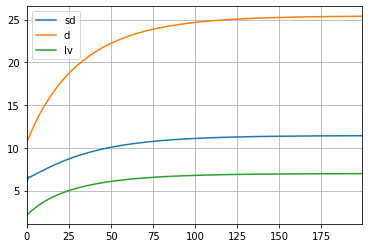

In [16]:
%matplotlib inline
from pandas import DataFrame
log=DataFrame(blue.log)
log[["sd","d","lv"]].plot(grid=True)

In [6]:
for c in Client.clients:
    print(Client.clients[c].handler)

### Eg.2
Still those two cars. Change the rule that the red car's speed follows. Set its speed to a constant value.

$d_{target}=5m$

$d_{real}\uparrow v_{blue}\uparrow$

$v_{blue}$ should decrease before $d_{real}=d_{target}$

When $v_{blue}=v_{red}$ and $d_{real}=d_{target}$, the system enter stable state.

In [5]:
from scenario import *

scen=Scenario()
left_edge=Line()
left_edge.add_point([-50,-3,0],[50,-3,0])
left_edge.color=Color(b=1)
left_edge.width=2
right_edge=Line()
right_edge.add_point([-50,3,0],[50,3,0])
right_edge.color=Color(b=1)
right_edge.width=2
scen.add(left_edge,right_edge)

class Agent(Cube):
    def __init__(self,color):
        Cube.__init__(self,4,1.8,1.48)
        self.color=color
        self.front=None
        self.local_velocity=Vector3()
        self.log=[]
        self.pid=PID(1.2,0.4,0)
        
    def on_step(self,dt):
        if self.front:
            safe_distance=self.velocity.norm().item()**2/9+6
            d=(self.front.position-self.position)[0].item()
            err=d-safe_distance
            self.local_velocity[0]=max(self.local_velocity[0]+self.pid.step(err,dt),0)
            self.log.append(dict(sd=safe_distance,d=d,err=err,lv=self.local_velocity[0].item(),v=self.velocity[0].item()))
        else:
#             self.local_velocity=Vector3(x=max(7.5-scen.t,0))
            self.local_velocity=Vector3(x=3*sin(scen.t)+3)
        
red=Agent(Color(r=1))
red.position=Vector3(-30,-1.5,0.74)

blue=Agent(Color(b=1))
blue.front=red
blue.position=Vector3(-40,-1.5,0.74)

scen.add(red,blue)
scen.render()

from time import sleep
scen.t=0
while scen.t<10:
    scen.step(0.1)
    sleep(0.1)
    scen.render()

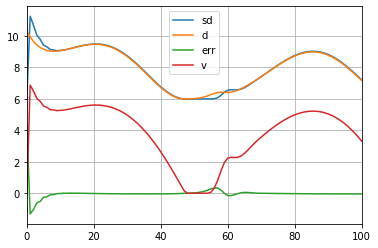

In [5]:
%matplotlib inline
from pandas import *
log=DataFrame(blue.log)
log[["sd","d","err","v"]].plot(grid=True)

In [6]:
from scenario import *
from pandas import *
scen=Scenario()
left_edge=Line()
left_edge.add_point([-50,-3,0],[50,-3,0])
left_edge.color=Color(b=1)
left_edge.width=2
right_edge=Line()
right_edge.add_point([-50,3,0],[50,3,0])
right_edge.color=Color(b=1)
right_edge.width=2
scen.add(left_edge,right_edge)

class Agent(Cube):
    def __init__(self):
        Cube.__init__(self,4,1.8,1.48)
        self.front=None
        self.local_velocity=Vector3()
        self.pid=PID(1.2,0.4,0)
        self.log=[]
        
    def on_step(self,dt):
        if self.front:
            safe_distance=self.velocity.norm().item()**2/9+6
            d=(self.front.position-self.position)[0].item()
            err=d-safe_distance
            self.local_velocity[0]=max(self.local_velocity[0]+self.pid.step(err,dt),0)
            self.log.append({"safe distance":safe_distance,"distance":d,"error":err,"local velocity":self.local_velocity[0].item(),"velocity":self.velocity[0].item()})
        else:
#             self.local_velocity=Vector3(x=max(10-scen.t,0))
            self.local_velocity=Vector3(x=3*sin(scen.t)+3)
        
front=None       
for i in range(10):
    a=Agent()
    a.position=Vector3(-50-10*i,-1.5,0.74)
    a.front=front
    scen.add(a)
    front=a
scen.render()
input("start")
from time import sleep
scen.t=0
while scen.t<20:
    scen.step(0.1)
    sleep(0.1)
    scen.render()

start 


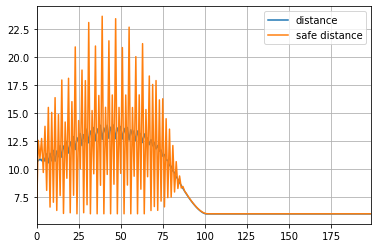

In [14]:
%matplotlib inline
from pandas import *
log=DataFrame(scen.objects[4].log)
log[["distance","safe distance"]].plot(grid=True)

### Eg.4
**Path Tracking**. A blue car tracks a given path. 

In [3]:
from scenario import *
from time import sleep
path=Line()
path.color=Color(g=0.3)
x=torch.linspace(-1.5,1.5)
y=torch.tan(x)
path.points=torch.empty(len(x),3)
path.points[:,0]=x
path.points[:,1]=y
path.points[:,2]=0.5
scen=Scenario()
scen.add(path)
car=Cube()
car.color=Color(b=0.8)
car.direction=Vector3(0,1,0)
car.position=path.points[0]+Vector3(0,0,0.5)
scen.add(car)
car.add(Line.Vector(car.direction))
for p in path.points:
    car.lookat(p)
    car.position=p
    scen.render()
    sleep(0.1)

### Eg.4

The red car do not move. The blue car change lane. After action, the blue car's rotation do not change, but position is forward and offset to left lane. Local velocity of the blue car do not change during the process.

In [3]:
from scenario import *

scen=Scenario()
left_edge=Line()
left_edge.add_point([-50,-3,0],[50,-3,0])
left_edge.color=Color(b=1)
left_edge.width=2
right_edge=Line()
right_edge.add_point([-50,3,0],[50,3,0])
right_edge.color=Color(b=1)
right_edge.width=2
scen.add(left_edge,right_edge)

class Agent(Cube):
    def __init__(self,color):
        Cube.__init__(self,4,1.8,1.48)
        self.color=color
        self.front=None
        self.pid=PID(0.02,0.0,0.0)
        self.turning=True
        self.log=[]
        
    def on_step(self,dt):
        if self.front and self.turning:
            self.turn_left(dt)
        
    def turn_left(self,dt):
        r=self.rotation.to_eular()[2]
        d=0.75-self.position[1]
        err=d
        av=self.pid.step(err,dt)
        self.local_angular_velocity=Rotation.Eular(0,0,av)
        self.log.append({"t":scen.t,"yaw":r,"y distance":d,"error":err,"angular velocity":av})
        if abs(d)<0.1 and abs(r)<0.1:
            self.turning=False
            self.local_angular_velocity=Rotation()
        
red=Agent(Color(r=1))
red.position=Vector3(-30,-1.5,0.74)
blue=Agent(Color(b=1))
blue.front=red
blue.position=Vector3(-40,-1.5,0.74)
blue.local_velocity=Vector3(2,0,0)
blue.add(Line.Vector(4*blue.direction))
path=Line()
scen.add(red,blue,path)

from time import sleep
scen.t=0
while scen.t<40:
    scen.step(0.1)
    path.add_point(blue.position)
    sleep(0.1)
    scen.render()

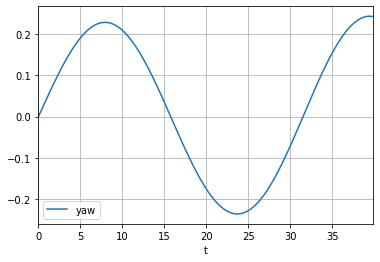

In [16]:
%matplotlib inline
from pandas import *
log=DataFrame(blue.log)
log[["t","yaw"]].plot(x="t",y="yaw",grid=True)

### Eg.5

In [41]:
from scenario import *
l=Line()
l.color=Color(r=1)
x=torch.linspace(0,100,10)
l.points=torch.zeros(len(x),3)
l.points[:,0]=x
l.points[:,1]=4
l.points[1]=0.7*l.points[2]+0.3*Vector3()
l.points[2]=0.7*l.points[3]+0.3*l.points[1]
s1=Sphere(0.2)
s1.position=l.points[1]
s2=Sphere(0.2)
s2.position=l.points[2]
scen=Scenario()
scen.add(l,s1,s2)
scen.render()

In [19]:
def set_d(**param):
    print(param)
set_d(d=1)

{'d': 1}
